In [5]:
#imports
import datetime
import fiona
import gc
import glob
import os
import warnings
import rioxarray
import geopandas as gpd
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats import norm

from myfunctions import clip_ds_monthly
from params import allnames, experiment_ids
from params import savepath

xr.set_options(display_style='html')
plt.style.use('./science.mplstyle')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False

from params import homedir

warnings.simplefilter("ignore", category=RuntimeWarning)

/tmp/ipykernel_51995/3434809964.py:30: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  ng.index = 0
TopologyException: Input geom 1 is invalid: Self-intersection at -73.151101703240116 -37.035200167727147


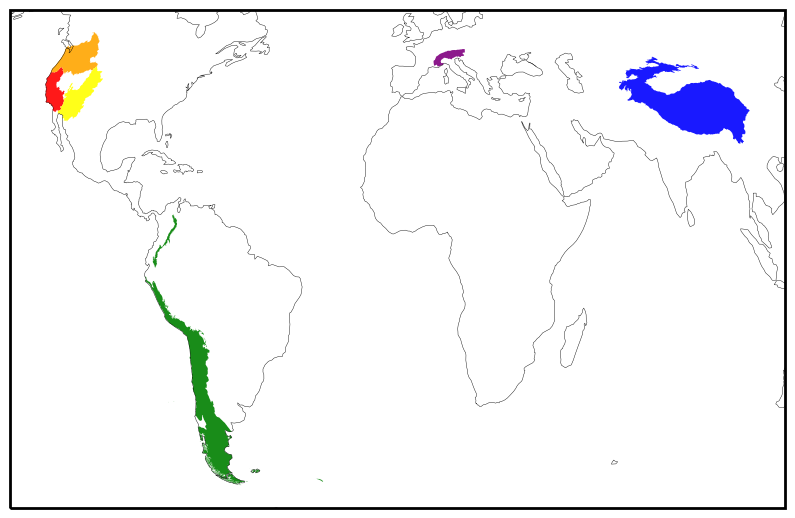

In [2]:
## LOAD SHAPEFILES FOR MAJOR WATER TOWER BASINS ##
huc2fn = homedir + 'data/huc2.shp'
basins = gpd.read_file(huc2fn) # ,layer = 'WBDHU2')
caregion = basins.loc[12]
# CO (upper and lower)
colorado1 = basins[(basins.index == 9)]
colorado1.index= [0]
colorado2 = basins[(basins.index == 13)]
colorado2.index= [0]
coloradogeom = colorado1.geometry.union(colorado2.geometry)
colorado = gpd.GeoDataFrame({'name':'Colorado'},index = [0], geometry = coloradogeom)
# PNW
pnw = basins[(basins.index == 15)]
pnw.index = [0]
# CA
california = basins[(basins.index == 12)]
california.index = [0]
#GMBA
GMBA = gpd.read_file(homedir + 'data/GMBA_mountain_inventory.shp')
# Pan-Tibetan Highlands
pth_extents = gpd.read_file('https://github.com/xinluo2018/High-Moutain-Asia-GIS-Data/raw/e26c00bdd56f172773f8a85348f3e3c4047467a1/extents/HMA/hma(Pan_TPlateau)_liu2022_subregions.gpkg')
import shapely
gen = shapely.ops.polygonize(pth_extents.geometry[0])
pth = next(gen)
pth = gpd.GeoDataFrame({'name':'Pan-Tibetan Highlands'},index=[0], crs='epsg:4326', geometry=[pth])       
# Andes
andina = gpd.read_file(homedir + 'data/RegionAndina.shp')
geom = andina.geometry[0]
for ng in andina.geometry:
    ng.index = 0
    try:
        geom = geom.union(ng)
    except:
        continue
andes = gpd.GeoDataFrame({'name':'Andes'}, index=[0], crs = 'epsg:4326', geometry = [geom])
# ALPS
alps = GMBA[GMBA.index == 583]
alps = gpd.GeoDataFrame({'name':alps.Name[583]},index = [0],  crs = 'epsg:4326', geometry = [alps.geometry[583]])

basins_to_plot = [colorado, california, pnw, pth, andes, alps]

fig = plt.figure(figsize=(10,10))
proj = ccrs.EqualEarth()
alpha =0.9
ax = fig.add_subplot(1,1,1,projection=proj)
california.to_crs(proj).plot(ax=ax, color = 'red', linewidth = 1, alpha = alpha)
pnw.to_crs(proj).plot(ax=ax, color = 'orange', linewidth = 1, alpha = alpha)
pth.to_crs(proj).plot(ax=ax, color = 'blue',linewidth = 1 ,alpha = alpha)
andes.to_crs(proj).plot(ax=ax, color = 'green',linewidth = 1, alpha = alpha)
alps.to_crs(proj).plot(ax=ax, color = 'purple', linewidth = 1, alpha =alpha)
colorado.to_crs(proj).plot(ax=ax, color = 'yellow', linewidth = 1, alpha =alpha)
ax.coastlines(lw=0.3)
ax.set_extent = ([-360, 0 , -90, -50], ccrs.PlateCarree())  
plt.show()

In [55]:
files = glob.glob(savepath +  'swei_[!imm]*')
s245data = []
s585data = []
def max_month(sweidata):
    data_filled = np.nan_to_num(sweidata, nan=-999)
    maxmonth = np.nanmedian(np.nanargmax(data_filled,axis = 1),axis=0).astype(int)# .shape
    i, j = np.meshgrid(np.arange(sweidata.shape[2]), np.arange(sweidata.shape[3]), indexing='ij')
    swei_maxmonth = sweidata[:,maxmonth, i, j]
    return swei_maxmonth

for fn in sorted(files):
    model = fn.split('_')[-2]# [0:-4]
    if model in allnames:
        era = fn.split('ssp')[-1][0:3]
        sweidata = np.load(fn)
        clip = max_month(sweidata)
        if era == '585':
            s585data.append(clip)
        elif era == '245':
            s245data.append(clip)

In [127]:
## MASKS AND COORDS ## 
tmp = xr.open_dataset(savepath + 'snw_UKESM1-0-LL-185001_201412_historical.nc')
coord = [tmp['lat'],tmp['lon']]
landmask = xr.open_dataset(savepath + 'land_mask.nc')['mask'][0]
sftgif = xr.open_dataset(savepath + 'sftgif_rg.nc')
pct = sftgif['sftgif'][0][0]
icemask = pct < 5
landicemask = (icemask.values & landmask.values)

In [57]:
np.save(savepath + 's585data', s585data)
np.save(savepath + 's245data', s245data)

In [65]:
s245arr = np.zeros((9,249,160,320))
s585arr = np.zeros((9,249,160,320))
for i in range(9):
    val = s245data[i]
    if val.shape[0] == 249:
        s245arr[i] = val
        s585arr[i] = s585data[i]

In [178]:
## prep data for plotting ##
## this cell requires 7+ GB of available memory and takes a few minutes ##

## SSP 585 ##
nyr = 10
npd = int((2100-1850)/nyr)
nmod = len(s245arr)
lines = {}
for basin in basins_to_plot:
    lines[basin.name[0]] = []
    for i in range(npd):
        lines[basin.name[0]].append([])
        
        ## 245 data ##
for i in range(nmod):
    categ = s245arr[i]
    
    xdsvar = xr.Dataset(
        data_vars=dict(
            swei=(["ensyear","lat","lon"],categ),
        ),
        coords=dict(
            lon=(["lon"], np.array(coord[1])),
            lat=(["lat"], np.array(coord[0])),
            ensyear=range(categ.shape[0]),
        ),
    )
    for idx,basin in enumerate(basins_to_plot):
        clipped = clip_ds_monthly(xdsvar, basin = basin, lon_name = 'lon')
        data = clipped.swei.values.flatten()
        allmeans = np.nanmean(clipped.swei[:,:,:],axis=(1,2)).flatten()
        for i in range(npd):
            data2 = allmeans[i*nyr:((i*nyr)+nyr)]
            lines[basin.name[0]][i].append(data2)
            del data2
        gc.collect()
        del clipped, data
    gc.collect()
    del categ
    del xdsvar
    
    
## SSP 585 ##
lines2 = {}
for basin in basins_to_plot:
    lines2[basin.name[0]] = []
    for i in range(npd):
        lines2[basin.name[0]].append([])
        
for i in range(nmod):
    categ = s585arr[i]
    xdsvar = xr.Dataset(
        data_vars=dict(
            swei=(["ensyear","lat","lon"],categ),
        ),
        coords=dict(
            lon=(["lon"], np.array(coord[1])),
            lat=(["lat"], np.array(coord[0])),
            ensyear=range(categ.shape[0]),
        ),
    )
    for idx,basin in enumerate(basins_to_plot):
        clipped = clip_ds_monthly(xdsvar, basin = basin, lon_name = 'lon')
        data = clipped.swei.values.flatten()
        allmeans = np.nanmean(clipped.swei[:,:,:],axis=(1,2)).flatten()
        for i in range(npd):
            data2 = allmeans[i*nyr:((i*nyr)+nyr)]
            lines2[basin.name[0]][i].append(data2)
        gc.collect()
        del clipped, data
    gc.collect()
    del categ
    del xdsvar


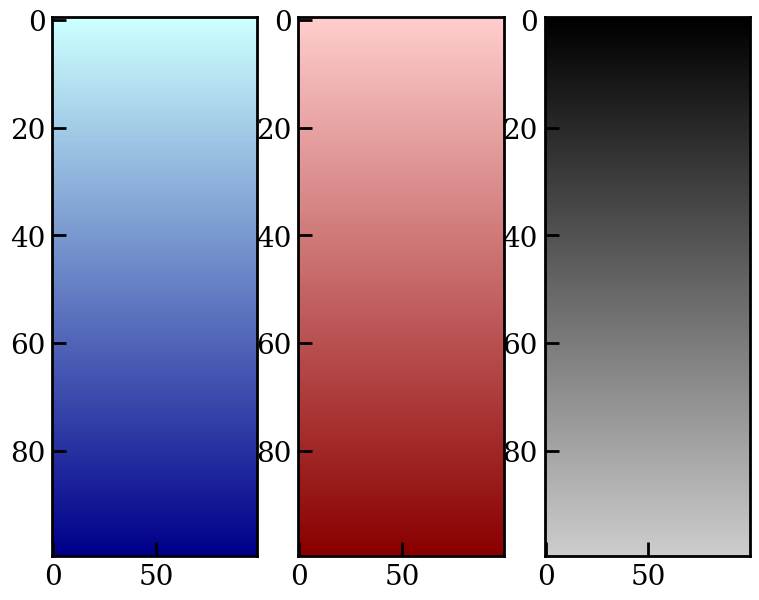

In [152]:
cdicthist = {'red': [(0.0,  0.0, 0.0),
                     (1.0,  0.8, 0.8)],
             'blue': [(0.0,  0.0, 0.0),
                      (1.0,  0.8, 0.8)],
             'green': [(0.0,  0.0, 0.0),
                       (1.0,  0.8, 0.8)],} 

cdict585 = {'red': [(0.0, 1, 1),
                    (1.0,  0.545, 0.545)],
            'blue': [(0.0,  0.8, 0.8),
                     (1.0,  0.0, 0.0)],
            'green': [(0.0,  0.8, 0.8),
                      (1.0,  0.0, 0.0)],}

cdict245 = {'blue': [(0.0,  1.0, 1.0),
                     (1.0,  0.545, 0.545)],
            'red': [(0.0,  0.8, 0.8),
                    (1.0,  0.0, 0.0)],
            'green': [(0.0,  1.0, 1.0),
                      (1.0,  0.0, 0.0)],} 


cmap245 = mpl.colors.LinearSegmentedColormap('ssp245',cdict245,256)
cmap585 = mpl.colors.LinearSegmentedColormap('ssp585',cdict585,256)
cmaphist = mpl.colors.LinearSegmentedColormap('ssphist',cdicthist,256)


a=np.outer(np.arange(0,1,0.01),np.ones(100))

fig,axs = plt.subplots(1,3)
axs[0].imshow(a,aspect='auto', cmap =cmap245)                   
axs[1].imshow(a,aspect='auto', cmap =cmap585)                   
axs[2].imshow(a,aspect='auto', cmap =cmaphist)                   
plt.show()


/tmp/ipykernel_51995/1283317925.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


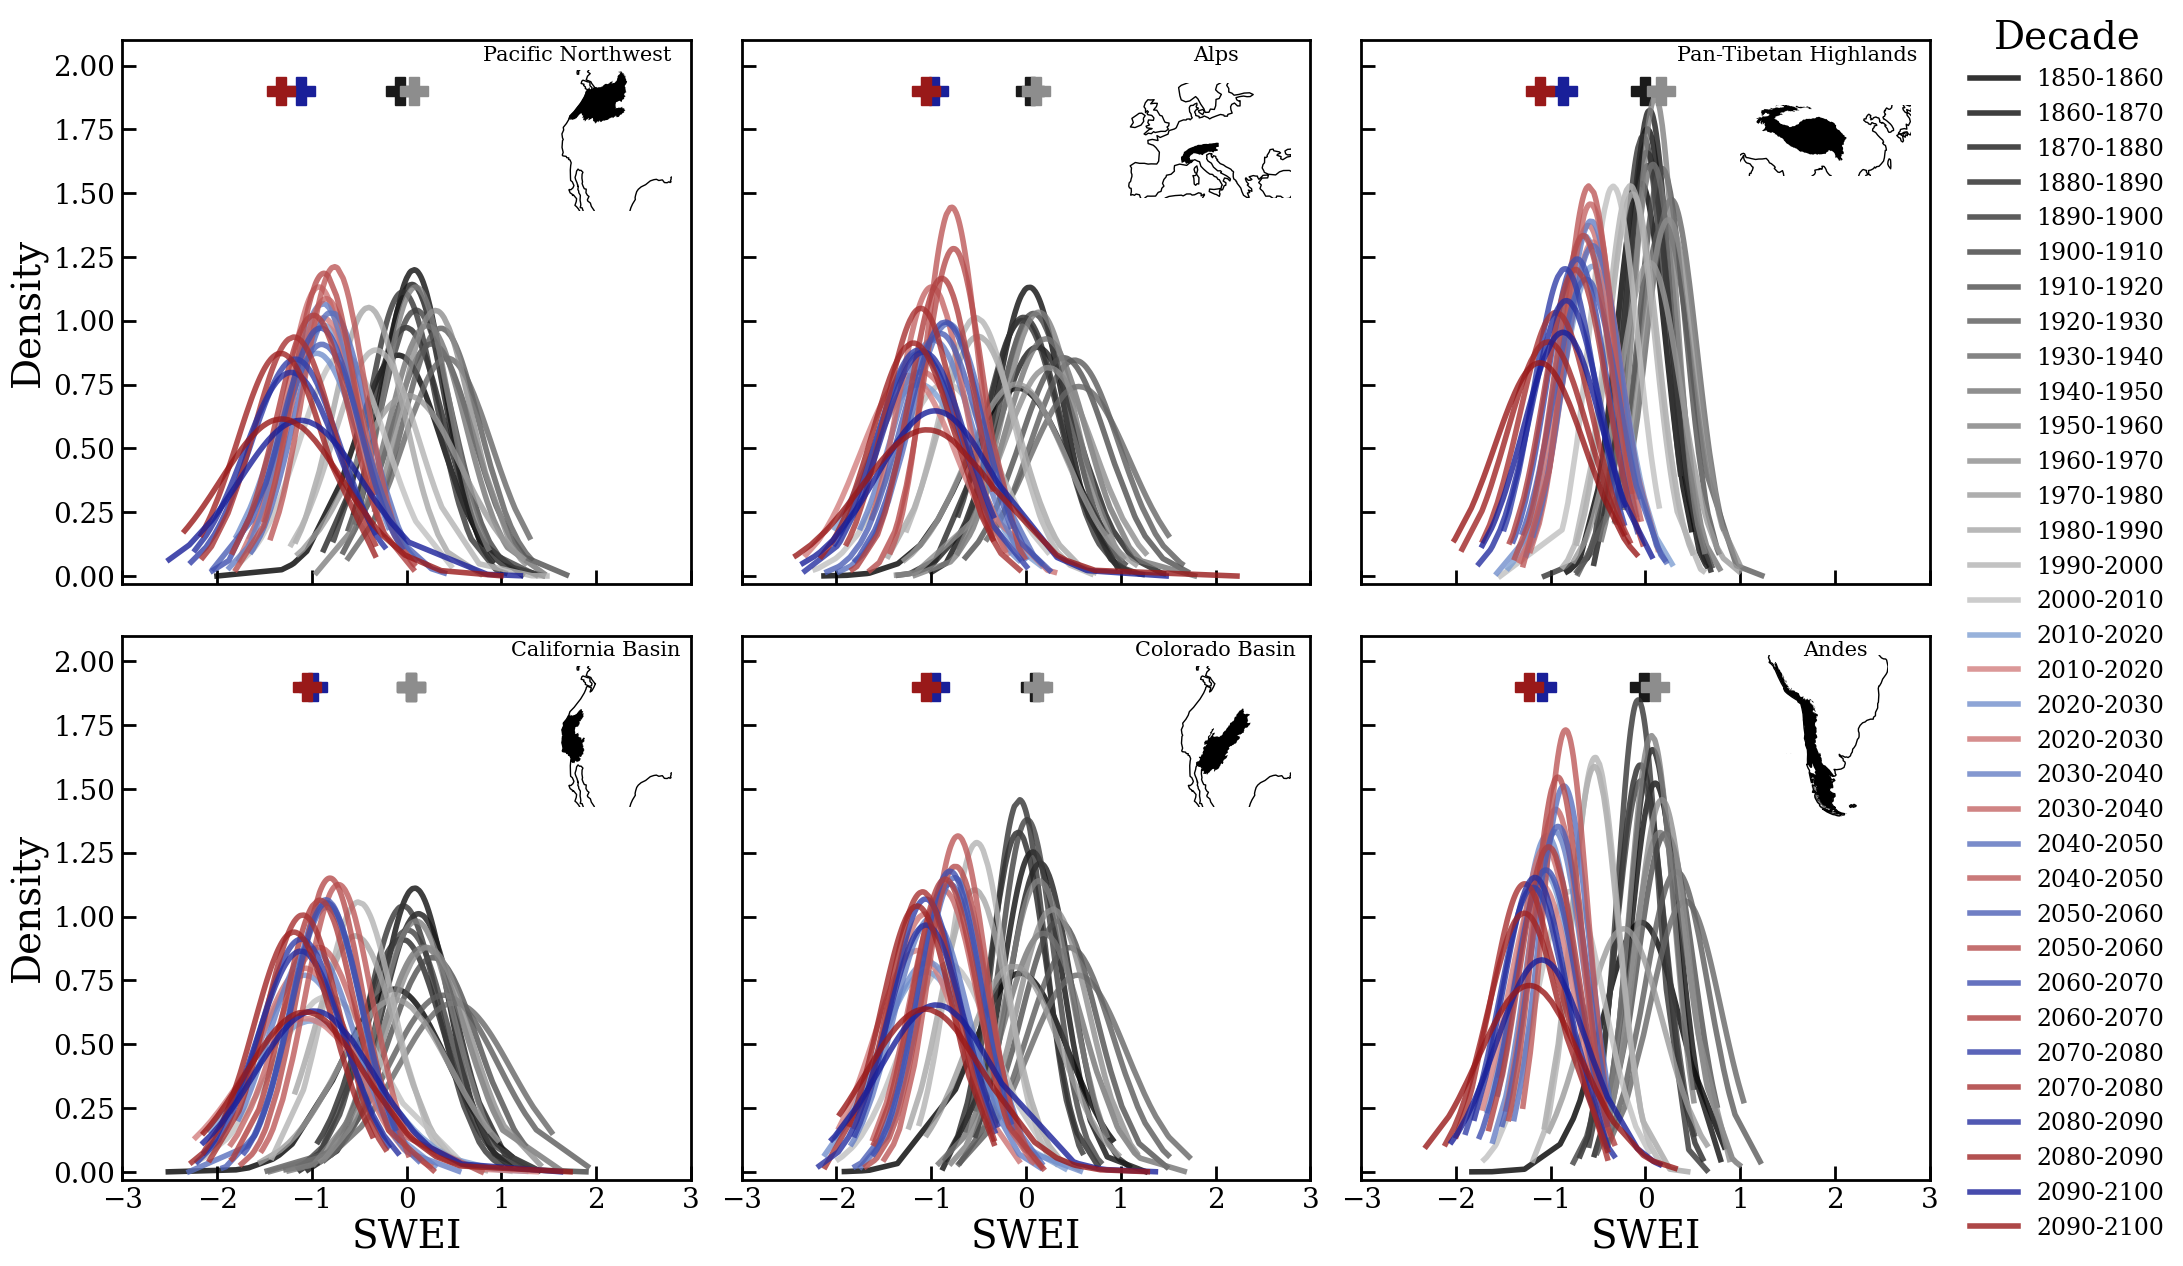

In [186]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
coast = gpd.read_file(homedir + '/data/ne_110m_coastline.shp')
from scipy.stats import norm

## aesthetics ##
nyr = 10
npd = int((2100-1850)/nyr)
colors_hist = cmaphist(np.linspace(0,1,int(npd/2)+5))
colors_245 = cmap245(np.linspace(0,1,int(npd/2)+5))
colors_585 = cmap585(np.linspace(0,1,int(npd/2)+5))
dotht = 1.9
alpha = 0.8
## ##


## put them in approx geographical order
basins_to_plot = [pnw, alps, pth, california, colorado, andes]
## title and x location of title to plot in the subplot ## 
titles = [('Pacific Northwest',1.8), 
          ('Alps', 2),
          ('Pan-Tibetan Highlands',1.6),
          ('California Basin',2),
          ('Colorado Basin', 2),
          ('Andes',2)]

#baseline adjustments
baselines = []
for basin in basins_to_plot:
    name = basin.name[0]
    data = np.array(lines[name][0:5]).flatten()
    baselines.append(np.nanmean(data))
    
    
fig,ax=plt.subplots(2,3,figsize=(20,13))
axs = ax.flatten()
for idx,basin in enumerate(basins_to_plot):
    name = basin.name[0]
    baseline = baselines[idx]
    for i in range(0,int(npd/2)+4):
        data = lines[name][i]
        data2 = np.array(data).flatten() -baseline
        pdf = pd.DataFrame(data = norm.pdf(data2 , loc = np.nanmean(data2), scale = np.nanstd(data2)), index = data2).sort_index()
        decade = str(1850+i*nyr) + '-' + str(1850+i*nyr+nyr)
        if idx == 5:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_hist[i],label = decade, alpha = alpha)
        else:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_hist[i], alpha = alpha)
        if i in [2,int(npd/2)-1, npd-1]:
            axs[idx].plot(pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())], dotht, color = colors_hist[i],marker = 'P', markersize = 20)
            #print('subplot', idx, 'line number ', i, 'value ', pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())])

    for i in range(int(npd/2)+4, npd):
        starti = int(npd/2)-2
        ## ssp 245 #E
        data = lines[name][i]
        data2 = np.array(data).flatten() - baseline
        pdf = pd.DataFrame(data = norm.pdf(data2 , loc = np.nanmean(data2), scale = np.nanstd(data2)), index = data2).sort_index()
        decade = str(1850+i*nyr) + '-' + str(1850+i*nyr+nyr)
        if idx == 5:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_245[i-starti],label = decade, alpha = alpha)
        else:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_245[i-starti], alpha = alpha)
        if i in [2,int(npd/2)-1, npd-1]:
            axs[idx].plot(pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())], dotht, color = colors_245[i-starti],marker = 'P', markersize = 20)
            # print('subplot', idx, 'line number ', i, 'value ', pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())])

        ## ssp 585 ##
        data = lines2[name][i]
        data2 = np.array(data).flatten() - baseline
        pdf = pd.DataFrame(data = norm.pdf(data2 , loc = np.nanmean(data2), scale = np.nanstd(data2)), index = data2).sort_index()
        decade = str(1850+i*nyr) + '-' + str(1850+i*nyr+nyr)
        if idx == 5:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_585[i-starti], alpha = alpha, label = decade)
        else:
            axs[idx].plot(pdf.groupby(pdf.index).mean() ,'-', linewidth = 4, color = colors_585[i-starti], alpha = alpha)
        if i == npd-1:
            axs[idx].plot(pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())], dotht, color = colors_585[i-starti],marker ='P', markersize = 20)
            # print('subplot', idx, 'line number ', i, 'value ', pdf.index[np.nanargmax(pdf.groupby(pdf.index).mean())])
    
    #axs[idx].set_title(basin.name[0])
    axs[idx].text(titles[idx][1],dotht+0.12,titles[idx][0], fontsize = 15,  ha="center")
    axs[idx].set_xlim((-3,3))
    axs[idx].set_ylim((-0.03,2.1))
    axs[idx].tick_params(direction="in")
    gc.collect()
    
[axs[i].set_xlabel('SWEI') for i in [3,4,5]]
[axs[i].set_ylabel('Density') for i in [0,3]]
[axs[i].tick_params(labelbottom = False) for i in [0,1,2]]
[axs[i].tick_params(labelleft = False) for i in [1,2,4,5]]

## add geometries ##
kwargs = {'frameon':False,
         'xticklabels': [],
         'yticklabels': []}

## basin object with shape included, xlims, ylims  ##
geom_args = [(pnw, [-1.2e7,-0.8e7], [3.0e6,6.3e6]),
             (alps, [-0.1e7,0.3e7], [4.5e6,7.2e6]),
             (pth, [0.5e7,1.2e7], [2.5e6,5.4e6]),
             (california, [-1.2e7,-0.8e7], [3.0e6,6.3e6]),
             (colorado, [-1.2e7,-0.8e7], [3.0e6,6.3e6]),
             (andes, [-0.8e7,-.33e7], [-6.6e6,-0.5e6])]

for i, geom_arg in enumerate(geom_args):
    inset_ax = inset_axes(axs[i], width="30%",  height="30%", loc=1, borderpad = 0.8, axes_kwargs=kwargs)
    inset_ax.tick_params(bottom=False)
    inset_ax.tick_params(left=False)
    # inset_ax.text(0,0,basins_to_plot[i].name[0])
    geom_arg[0].to_crs(proj).plot(ax=inset_ax, color = 'k', linewidth = 1, alpha = 1)
    coast.to_crs(proj).plot(ax=inset_ax, linewidth = 1)
    inset_ax.set_xlim(geom_arg[1])
    inset_ax.set_ylim(geom_arg[2]) 

fig.legend(title = 'Decade', bbox_to_anchor=(1.1, 1.),ncol=1)
fig.tight_layout()
plt.show()
fig.savefig('../figures/fig3.png')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


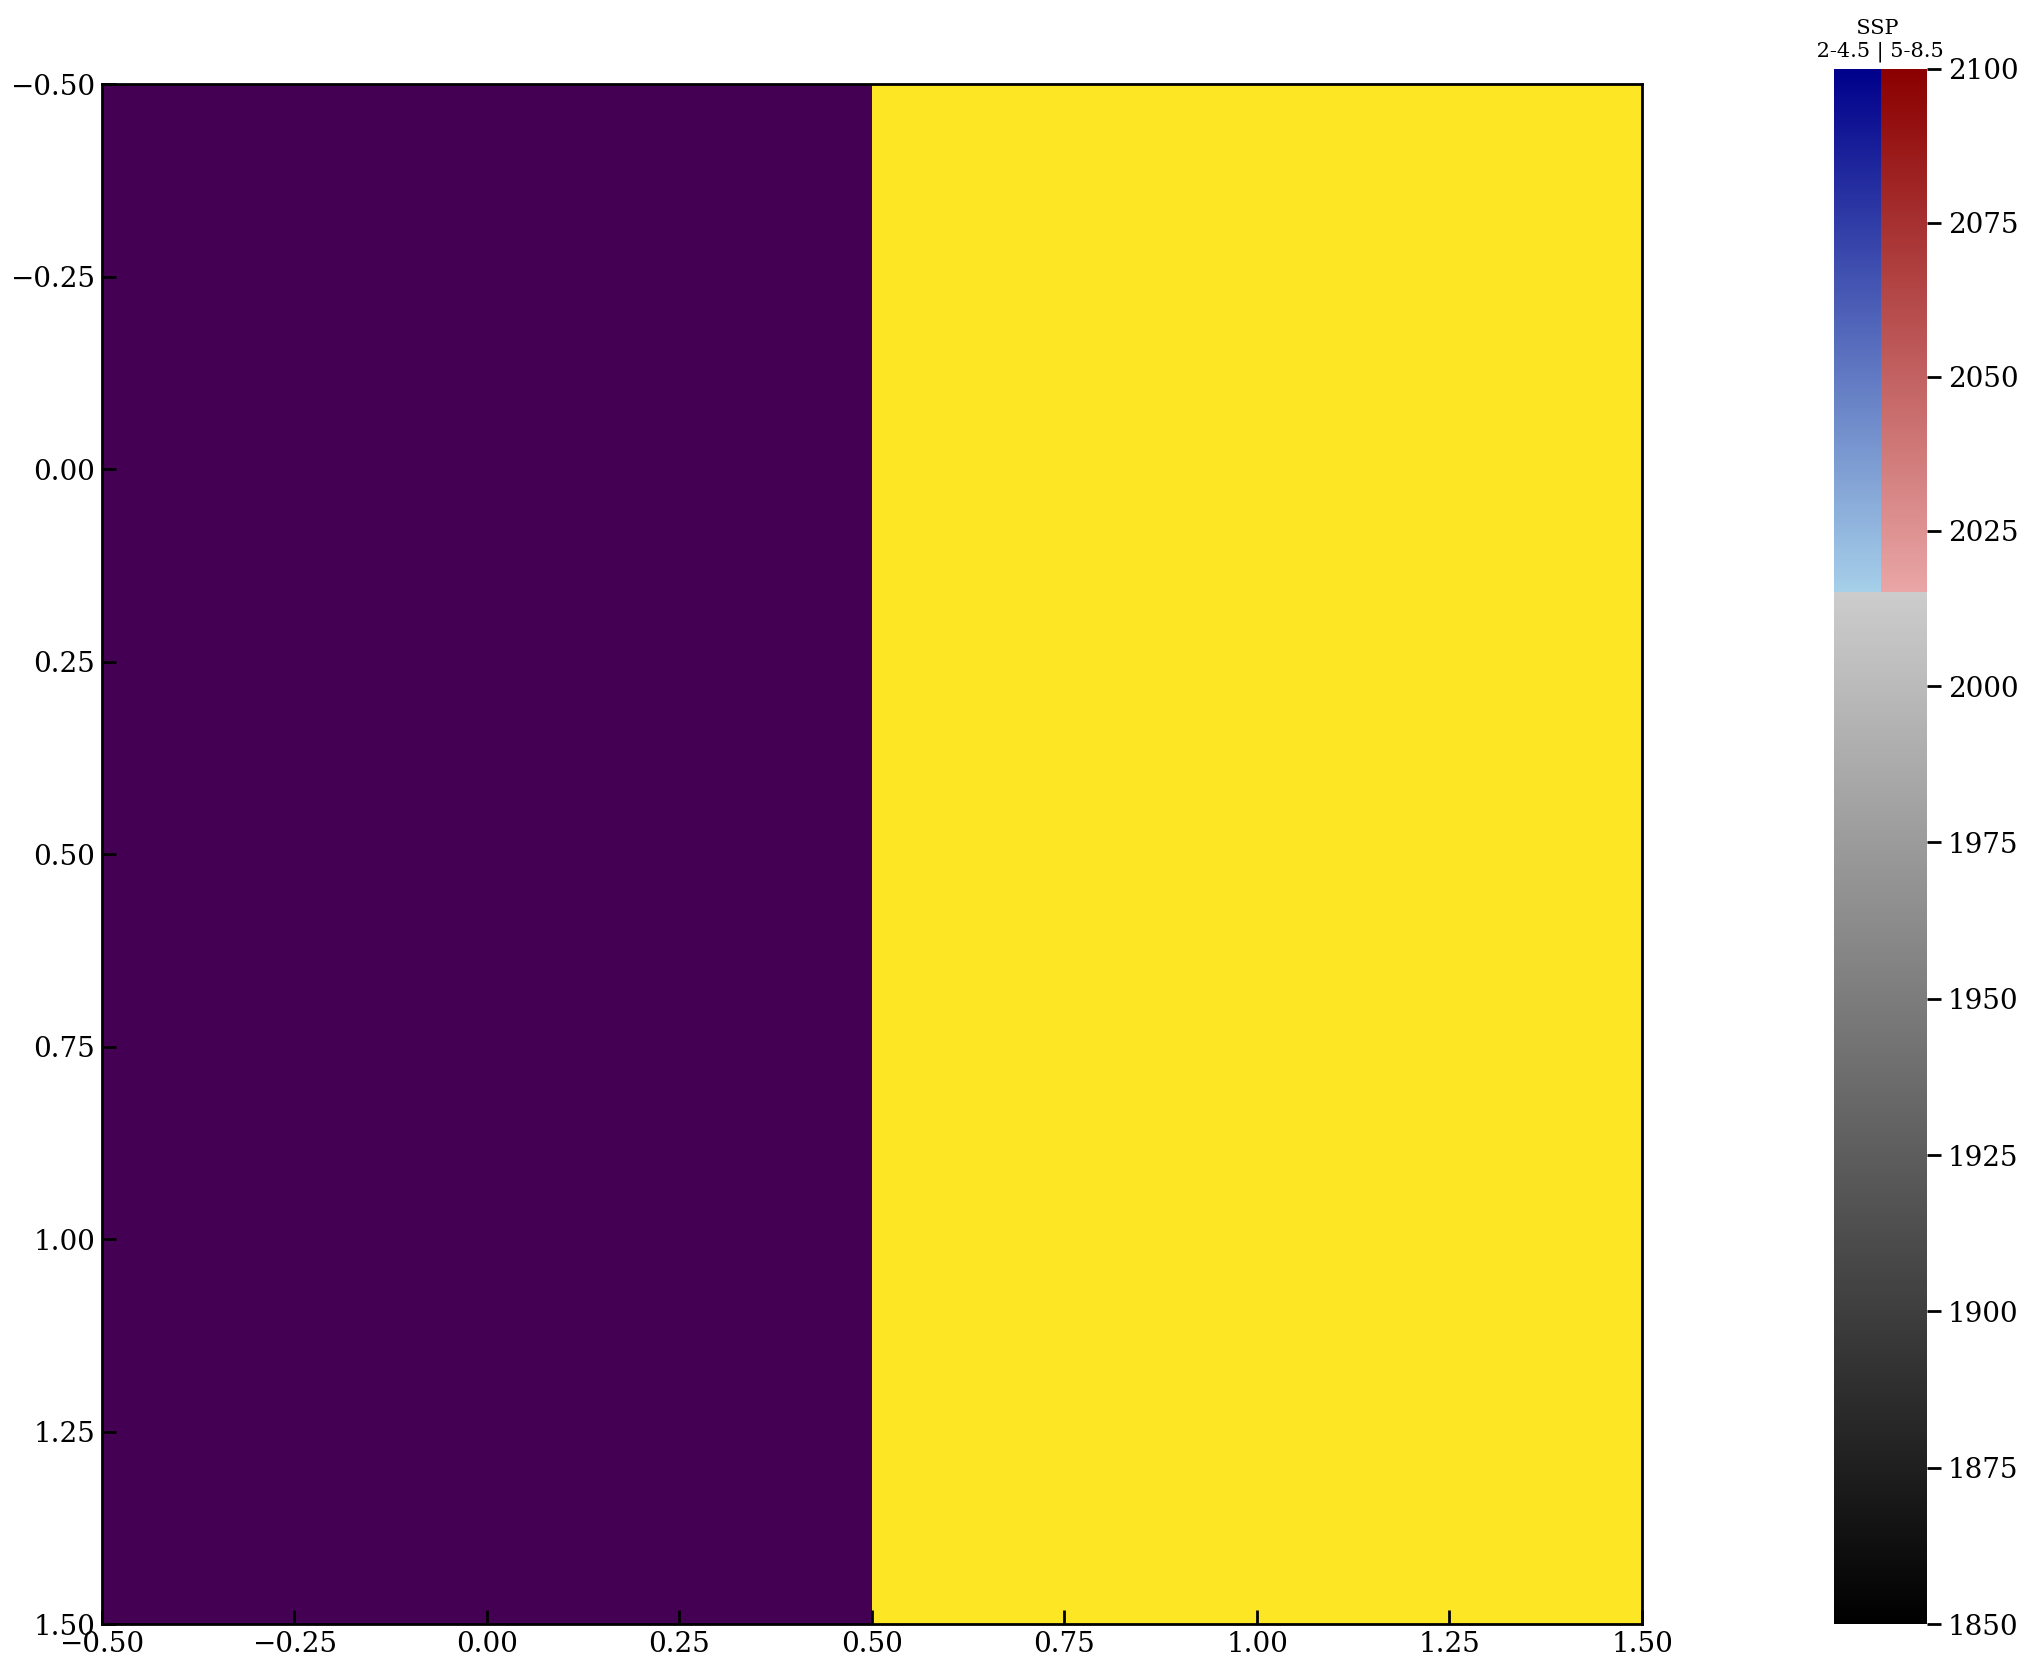

In [188]:
## generate replacement colormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
colors1 = cm.coolwarm(np.linspace(0,1,npd))[0:int(npd/2)] ##1 = Red
colors2 = cm.coolwarm(np.linspace(0,1,npd))[int(npd/2):-1] ## 2 = Blue
colors3 = cm.Greys(np.linspace(0,1,npd))[int(npd/2):-1] ## 3 = Gray
mymap1 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_hist)
mymap2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_245[3:])
mymap3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_585[3:])

fig, ax = plt.subplots(figsize=(20,20))
im1 = ax.imshow(np.meshgrid([[1850,2015],[1850,2015]]), cmap = mymap1)
im2 = ax.imshow(np.meshgrid([[2015,2100],[2015,2100]]), cmap = mymap2)
im3 = ax.imshow(np.meshgrid([[2015,2100],[2015,2100]]), cmap = mymap3)
im4 = ax.imshow([[0,1],[0,1]])

axins1 = inset_axes(ax,
    width="6%",  # width: 5% of parent_bbox width
    height="67%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.125, 0.0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins2 = inset_axes(
    ax,
    width="3%",  # width: 5% of parent_bbox width
    height="34%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.125, 0.67, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins3 = inset_axes(
    ax,
    width="3%",  # width: 5% of parent_bbox width
    height="34%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.155, 0.67, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cb = plt.colorbar(im1, cax=axins1, ticks=np.linspace(1850,2100,int(npd/2)-1), drawedges=False)
cb.ax.tick_params(axis='y', direction='out')
cb.outline.set_visible(False)
cb = plt.colorbar(im2, cax=axins2, ticks=[])
cb.outline.set_visible(False)
cb=plt.colorbar(im3, cax=axins3, ticks=np.linspace(1850,2100,int(npd/2)-1))
cb.ax.tick_params(axis='y', direction='out')
cb.outline.set_visible(False)
fig.legend(title = '       SSP\n 2-4.5 | 5-8.5', bbox_to_anchor=(1.059, 0.923),ncol=1,title_fontsize=15,alignment = 'center')
plt.show()
fig.savefig('../figures/colorbar3.png')
